In [ ]:
#%matplotlib notebook
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell

In [ ]:
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split,  cross_validate, KFold, cross_val_score, RepeatedKFold,GridSearchCV

from statsmodels.genmod.generalized_linear_model import GLM
from pandas.plotting import scatter_matrix
from scipy.stats import boxcox
pd.set_option('display.max_columns', None)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import confusion_matrix, \
                  classification_report, accuracy_score,  precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,GradientBoostingClassifier,StackingClassifier,ExtraTreesClassifier
import graphviz

## PREPROCESSAT

Llegim el fitxer de dades i mirem les seves columnes

In [ ]:
dataset = read_csv("dataset.csv", header=0, delimiter=',', na_values='?')

dataset.shape

(1408, 45)

In [ ]:
dataset.columns

Index(['Rk', 'Player.x', 'Player_ID', 'Pos1', 'Pos2', 'Age', 'Tm', 'G', 'GS',
       'MP', 'FG', 'FGA', 'FG.', 'X3P', 'X3PA', 'X3P.', 'X2P', 'X2PA', 'X2P.',
       'eFG.', 'FT', 'FTA', 'FT.', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS', 'Salary', 'mean_views', 'Season', 'Conference',
       'Role', 'Fvot', 'FRank', 'Pvot', 'PRank', 'Mvot', 'MRank', 'Score',
       'Play'],
      dtype='object')

*Per després poder fer dataset.xxx.notna() és necessari que els atributs de percentatge com X3P., o X2P., que contenen missing values, es diguin d'un altre manera, així que fem rename*

In [ ]:
dataset.rename(columns = {'FG.':'FGPer','X3P.':'X3PPer','Pos1':'Pos' ,'X2P.':'X2PPer', 'FT.':'FTPer', 'eFG.':'eFGPer'}, inplace=True)
dataset = dataset.drop(['Pos2'],axis=1)
dataset = dataset.drop(['Rk'],axis=1)
dataset = dataset.drop(['Player.x'],axis=1)
dataset=dataset.drop(['Player_ID'],axis=1)

In [ ]:
subset_cathegorics = dataset.loc[:,['Pos','Tm','Season','Conference','Role']]
subset_continuous = dataset.loc[:,['Age','G','GS','MP','FG','FGA','FGPer','X3P','X3PA','X3PPer','X2P','X2PA','X2PPer','eFGPer','FT','FTA','FTPer',
                                   'ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS','Salary','mean_views','Fvot','FRank','Pvot',
                                   'PRank','Mvot','MRank','Score']]
subset_target = dataset.loc[:,['Play']]

Primer haurem de tractar els missing values, després trobar outliers, posteriorment tractar els tipus diferents de variables, podem crear noves variables, i també normalitzar-les.




In [ ]:
#Input NaNs amb 0 als percentatges de tir (no han tirat)
dataset.X3PPer.fillna(0, inplace=True)
dataset.X2PPer.fillna(0, inplace=True)
dataset.eFGPer.fillna(0, inplace=True)
dataset.FTPer.fillna(0, inplace=True)
dataset.FGPer.fillna(0, inplace=True)

subset_continuous.X3PPer.fillna(0, inplace=True)
subset_continuous.X2PPer.fillna(0, inplace=True)
subset_continuous.eFGPer.fillna(0, inplace=True)
subset_continuous.FTPer.fillna(0, inplace=True)
subset_continuous.FGPer.fillna(0, inplace=True)

#Input NaNs amb 0 als atributs de vots de media i players (perquè són números 
#de l'1 al 10, i al imputar aquests valors pot assignar-se un "rank" alt a algun
#jugador "random" que realment no ha obtingut cap puntuació)

dataset.Pvot.fillna(0, inplace=True)
dataset.PRank.fillna(0, inplace=True)
dataset.Mvot.fillna(0, inplace=True)
dataset.MRank.fillna(0, inplace=True)

subset_continuous.Pvot.fillna(0, inplace=True)
subset_continuous.PRank.fillna(0, inplace=True)
subset_continuous.Mvot.fillna(0, inplace=True)
subset_continuous.MRank.fillna(0, inplace=True)

subset_continuous.isnull().sum()

Age             0
G               0
GS              0
MP              0
FG              0
FGA             0
FGPer           0
X3P             0
X3PA            0
X3PPer          0
X2P             0
X2PA            0
X2PPer          0
eFGPer          0
FT              0
FTA             0
FTPer           0
ORB             0
DRB             0
TRB             0
AST             0
STL             0
BLK             0
TOV             0
PF              0
PTS             0
Salary         62
mean_views    138
Fvot            0
FRank           0
Pvot            0
PRank           0
Mvot            0
MRank           0
Score           0
dtype: int64

In [ ]:
dataset_complete = dataset.dropna()
dataset_complete.shape

(1219, 41)

Fent aquestes dues comandes, veiem que només queden les files de jugadors que inclouen totes les dades, les altres (amb dades inicialitzades com a NaN al read_csv), queden eliminades. Els atributs amb més missing values són Pos2, i les categories de votació, a les quals si el jugador en qüestió no ha rebut cap vot ni per la premsa, ni pels jugadors ni pels aficionats, queda eliminat del dataset.
Tots els missing values estan identificats com a NaN, de manera que podem passar directament a imputar aquests valors, és a dir, a assignar valors, per k nearest neighbours: Per cada jugador amb algun missing value, mirem els k jugadors més similars (basant-nos en les altres estadístiques), i llavors copiar aquest valor

Tenim missing values als atributs següents: 'Salary' i 'mean_views', després d'imputar els altres atributs amb missing values a 0.
Ara per cada atribut amb missing values hem de imputar per knn 

In [ ]:
# create an instance of the KNN imputer
imputer = KNNImputer(n_neighbors=2)

# fit and transform the data
imputed_data = imputer.fit_transform(subset_continuous)
# create a new dataframe with the same column names
subset_continuous = pd.DataFrame(imputed_data, columns=subset_continuous.columns)

In [ ]:
subset_continuous[:10]
#Valors imputats correctament

,Age,G,GS,MP,FG,FGA,FGPer,X3P,X3PA,X3PPer,X2P,X2PA,X2PPer,eFGPer,FT,FTA,FTPer,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary,mean_views,Fvot,FRank,Pvot,PRank,Mvot,MRank,Score
0,24.0,22.0,0.0,7.4,0.8,1.9,0.405,0.2,0.5,0.500,0.5,1.5,0.375,0.464,0.4,0.9,0.450,0.4,1.3,1.6,0.2,0.0,0.6,0.5,1.0,2.2,1252144.0,3.320000,786.0,123.0,0.0,0.0,0.0,0.0,83.5
1,32.0,65.0,0.0,13.8,1.9,4.6,0.403,0.7,2.0,0.375,1.1,2.6,0.424,0.483,0.5,0.6,0.800,0.3,0.8,1.1,1.9,0.4,0.1,1.0,1.4,5.0,2700000.0,11.155738,2474.0,64.0,0.0,0.0,0.0,0.0,48.2
2,21.0,80.0,72.0,28.7,4.9,10.8,0.454,1.0,3.3,0.288,4.0,7.5,0.528,0.499,2.0,2.7,0.719,1.5,3.6,5.1,1.9,0.8,0.5,1.1,2.2,12.7,4351320.0,1713.986339,22774.0,29.0,0.0,0.0,0.0,0.0,40.0
3,25.0,18.0,0.0,7.5,1.3,3.0,0.426,0.2,0.8,0.200,1.1,2.2,0.513,0.454,0.8,1.1,0.737,0.5,1.3,1.8,0.4,0.4,0.4,0.4,1.8,3.5,2022240.0,205.855191,861.0,120.0,1.0,52.0,0.0,0.0,75.5
4,26.0,61.0,25.0,29.1,3.0,7.6,0.393,1.1,3.5,0.330,1.9,4.2,0.445,0.468,1.6,2.2,0.706,1.3,6.1,7.4,1.6,1.0,0.7,1.5,1.7,8.7,7680965.0,604.341530,4971.0,69.0,7.0,23.0,0.0,0.0,42.8
5,30.0,68.0,68.0,32.3,5.6,11.8,0.473,1.3,3.6,0.355,4.3,8.2,0.524,0.527,1.6,2.0,0.800,1.4,5.4,6.8,5.0,0.8,1.3,1.7,2.0,14.0,26540100.0,1556.382514,12219.0,14.0,8.0,16.0,2.0,6.0,12.5
6,32.0,66.0,1.0,14.1,3.6,7.1,0.499,0.0,0.0,0.000,3.6,7.1,0.500,0.499,1.0,1.3,0.765,1.1,3.1,4.2,0.9,0.3,0.2,0.5,1.9,8.1,10230179.0,603.188525,2936.0,84.0,1.0,60.0,0.0,0.0,60.0
7,34.0,30.0,0.0,10.3,1.0,2.7,0.375,0.5,1.5,0.318,0.5,1.2,0.444,0.463,0.4,0.5,0.750,0.1,0.7,0.8,0.4,0.1,0.0,0.2,1.2,2.9,1315448.0,5.409341,3096.0,88.0,1.0,52.0,0.0,0.0,59.5
8,24.0,47.0,0.0,15.1,2.9,5.7,0.517,0.0,0.0,0.000,2.9,5.7,0.519,0.517,1.5,2.4,0.625,2.0,4.2,6.2,0.5,0.6,0.7,0.8,2.7,7.4,874636.0,21.213115,607.0,127.0,0.0,0.0,0.0,0.0,85.5
9,25.0,42.0,0.0,15.5,2.4,5.9,0.399,0.6,1.8,0.329,1.8,4.1,0.430,0.450,1.4,1.9,0.769,0.4,2.5,2.9,0.7,0.4,0.1,0.8,1.2,6.7,9904495.0,122.505464,1981.0,72.0,0.0,0.0,0.0,0.0,53.0


In [ ]:
dataset = pd.concat([subset_cathegorics, subset_continuous, subset_target], axis=1)

In [ ]:
dataset.isnull().sum()

Pos           0
Tm            0
Season        0
Conference    0
Role          0
Age           0
G             0
GS            0
MP            0
FG            0
FGA           0
FGPer         0
X3P           0
X3PA          0
X3PPer        0
X2P           0
X2PA          0
X2PPer        0
eFGPer        0
FT            0
FTA           0
FTPer         0
ORB           0
DRB           0
TRB           0
AST           0
STL           0
BLK           0
TOV           0
PF            0
PTS           0
Salary        0
mean_views    0
Fvot          0
FRank         0
Pvot          0
PRank         0
Mvot          0
MRank         0
Score         0
Play          0
dtype: int64

Un cop tractats els missing values, fem una inspecció bàsica del dataset i de les correlacions entre les diferents variables d'aquest, mitjançant un heatmap.

In [ ]:
dataset.describe()

,Age,G,GS,MP,FG,FGA,FGPer,X3P,X3PA,X3PPer,X2P,X2PA,X2PPer,eFGPer,FT,FTA,FTPer,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary,mean_views,Fvot,FRank,Pvot,PRank,Mvot,MRank,Score
count,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.00000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1.408000e+03,1408.000000,1.408000e+03,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000,1408.000000
mean,26.139205,54.099432,25.906960,20.162713,3.262429,7.173153,0.446332,0.856250,2.420810,0.290536,2.406321,4.752770,0.491408,0.503952,1.417401,1.855327,0.716104,0.847514,2.824645,3.67017,1.935227,0.640767,0.402699,1.130540,1.726065,8.794176,6.680223e+06,915.980495,1.176963e+05,61.595170,7.216619,38.385653,2.095170,5.098011,75.578338
std,4.282550,24.052508,28.664578,9.066041,2.181694,4.591826,0.094679,0.792307,2.061737,0.146361,1.812374,3.427045,0.106432,0.098398,1.369218,1.678879,0.184254,0.769705,1.853155,2.48246,1.791822,0.416026,0.403687,0.803248,0.751721,6.081955,7.343502e+06,2048.779577,4.286272e+05,36.681104,25.022761,26.005078,12.607836,3.473575,41.404980
min,19.000000,1.000000,0.000000,0.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.684500e+04,1.142857,3.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,23.000000,36.000000,1.000000,13.300000,1.600000,3.700000,0.403000,0.200000,0.700000,0.256000,1.000000,2.100000,0.452000,0.473000,0.500000,0.700000,0.667000,0.300000,1.500000,1.90000,0.700000,0.300000,0.100000,0.600000,1.200000,4.300000,1.471382e+06,157.818493,2.135500e+03,30.000000,0.000000,16.000000,0.000000,0.000000,45.000000
50%,25.000000,62.000000,13.000000,20.000000,2.800000,6.150000,0.443000,0.700000,2.050000,0.333000,1.900000,3.800000,0.497000,0.510000,1.000000,1.300000,0.760000,0.600000,2.400000,3.10000,1.300000,0.600000,0.300000,0.900000,1.700000,7.300000,3.381740e+06,373.027476,6.843000e+03,60.000000,1.000000,39.000000,0.000000,7.000000,69.900000
75%,29.000000,74.000000,52.000000,27.500000,4.500000,9.900000,0.490000,1.300000,3.700000,0.372000,3.300000,6.700000,0.544000,0.549000,1.900000,2.500000,0.824000,1.100000,3.700000,4.70000,2.500000,0.900000,0.500000,1.500000,2.200000,12.000000,1.000000e+07,851.900685,2.925250e+04,90.250000,3.000000,60.000000,0.000000,8.000000,109.200000
max,42.000000,82.000000,82.000000,37.800000,10.800000,24.500000,1.000000,5.100000,13.200000,1.000000,9.700000,19.200000,1.000000,1.500000,9.700000,11.000000,1.000000,5.400000,11.100000,16.00000,11.200000,2.400000,2.700000,5.700000,4.000000,36.100000,3.745715e+07,34147.961644,4.620809e+06,145.000000,269.000000,88.000000,100.000000,9.000000,166.800000


<ipython-input-14-d7756877071c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = dataset.corr()


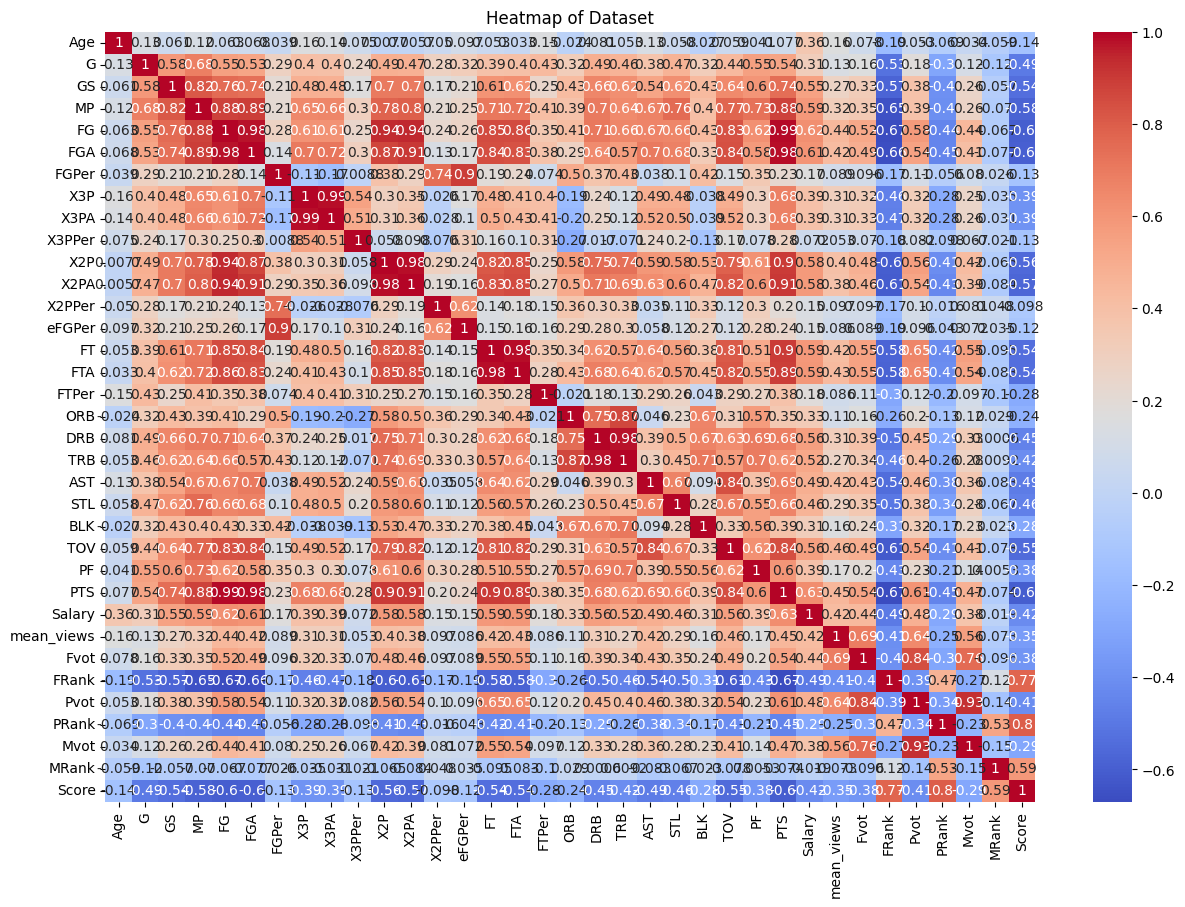

In [ ]:
correlation_matrix = dataset.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap of Dataset')
plt.show()

És d'esperar que per aplicar algunes de les tècniques vistes durant el curs sigui necessari tractar les variables categòriques, de manera que passin a ser numèriques i puguin ser incloses. Això es farà per mitjà de One Hot Encoding per cadascuna d'elles.

Abans, però, volem visualitzar la distribució de les nostres dades a la variable resposta segons alguns atributs.
És d'esperar que quant millor siguin les estadístiques d'un jugador, més probable sigui la seva elecció per l'All Star, però volem veure com afecten altres dades, com el salari a aquesta distribució.

Per reflexar això, treballarem amb una còpia del nostre dataset, on les variables a comparar estaran categoritzades. Al posterior anàlisis no ho estaran, és només per la visualització de les dades.

In [ ]:
data = dataset

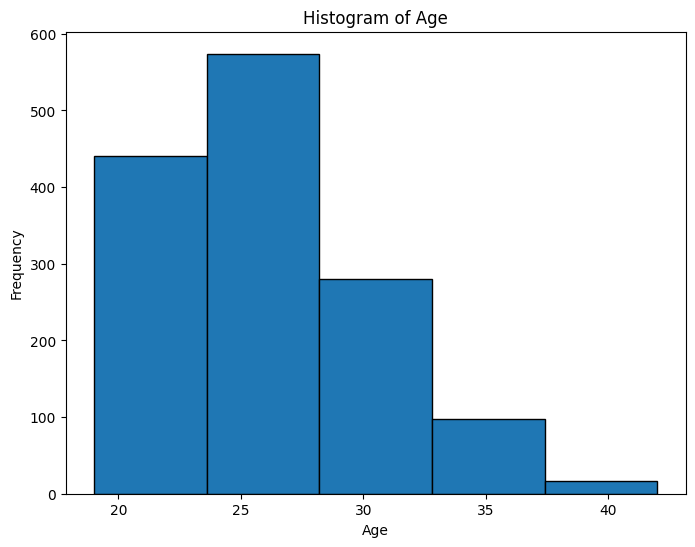

In [ ]:
variable = 'Age'

plt.figure(figsize=(8, 6))
plt.hist(dataset[variable], bins=5, edgecolor='black')
plt.title(f'Histogram of {variable}')
plt.xlabel(variable)
plt.ylabel('Frequency')
plt.show()

In [ ]:
intervals = [15, 24, 34, 44]
labels = ['15-24', '25-34', '35-44']

data['Age'] = pd.cut(data['Age'], bins=intervals, labels=labels, right=True)

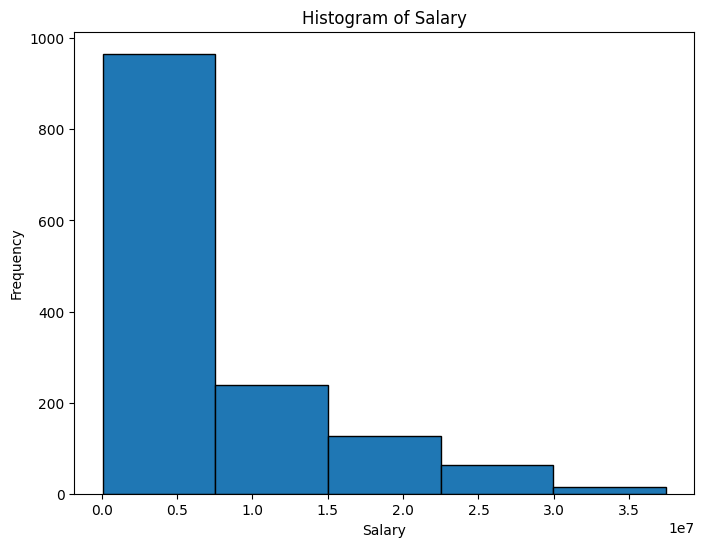

In [ ]:
variable = 'Salary'

plt.figure(figsize=(8, 6))
plt.hist(dataset[variable], bins=5, edgecolor='black')
plt.title(f'Histogram of {variable}')
plt.xlabel(variable)
plt.ylabel('Frequency')
plt.show()

In [ ]:
intervals = [0, 10000000, 20000000, float('inf')]
labels = ['0-1e7', '1e7-2e7', '+2e7']

data['Salary'] = pd.cut(data['Salary'], bins=intervals, labels=labels, right=True)

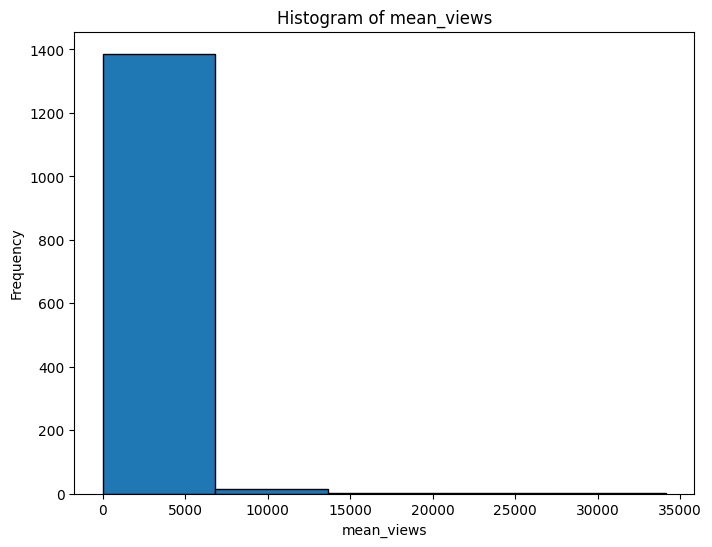

In [ ]:
variable = 'mean_views'

plt.figure(figsize=(8, 6))
plt.hist(dataset[variable], bins=5, edgecolor='black')
plt.title(f'Histogram of {variable}')
plt.xlabel(variable)
plt.ylabel('Frequency')
plt.show()

In [ ]:
intervals = [0, 5000, float('inf')]
labels = ['0-5000', '5000+']

data['mean_views'] = pd.cut(data['mean_views'], bins=intervals, labels=labels, right=True)

<Figure size 1000x600 with 0 Axes>

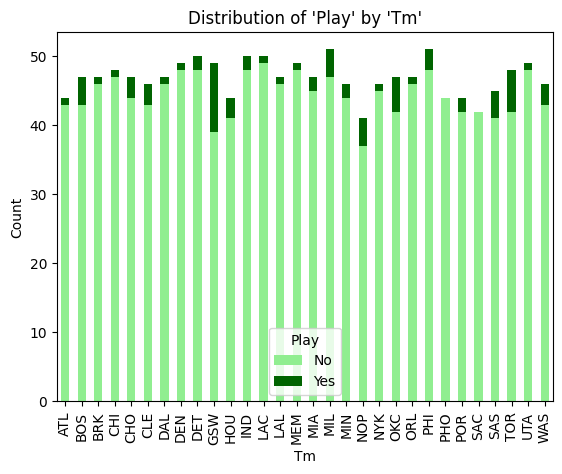

<Figure size 1000x600 with 0 Axes>

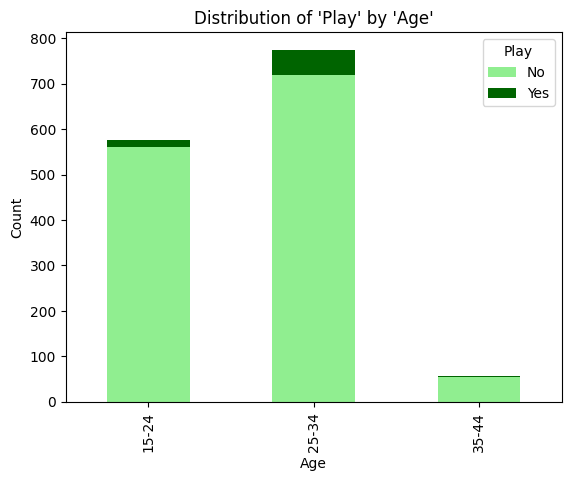

<Figure size 1000x600 with 0 Axes>

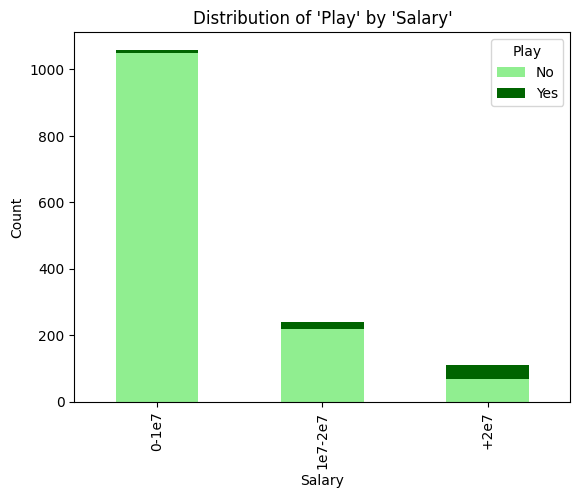

<Figure size 1000x600 with 0 Axes>

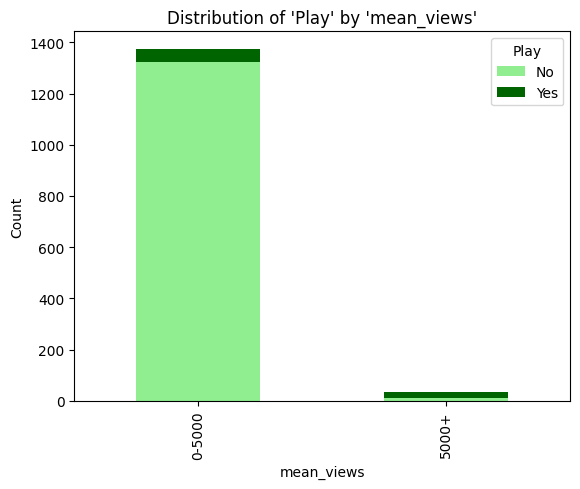

In [ ]:
categorical_variables = ['Tm', 'Age', 'Salary', 'mean_views']
target_variable = 'Play'
colors = ['#90EE90', '#006400'] # Verd clar i verd fosc

for variable in categorical_variables:
    plt.figure(figsize=(10, 6))
    grouped_data = data.groupby([variable, target_variable]).size().unstack()
    grouped_data.plot(kind='bar', stacked=True, color=colors)
    plt.title(f"Distribution of '{target_variable}' by '{variable}'")
    plt.xlabel(variable)
    plt.ylabel('Count')
    plt.legend(title=target_variable)
    plt.show()

ONE HOT ENCODING

In [ ]:
#One Hot Encoding pels equips
ohe = OneHotEncoder()
transformed = ohe.fit_transform(dataset[['Tm']])
print(ohe.categories_)

dataset[ohe.categories_[0]] = transformed.toarray()
dataset = dataset.drop(['Tm'],axis=1)
dataset[:4]

subset_cathegorics[ohe.categories_[0]] = transformed.toarray()
subset_cathegorics = subset_cathegorics.drop(['Tm'],axis=1)
subset_cathegorics[:4]

[array(['ATL', 'BOS', 'BRK', 'CHI', 'CHO', 'CLE', 'DAL', 'DEN', 'DET',
       'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN',
       'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHO', 'POR', 'SAC', 'SAS',
       'TOR', 'UTA', 'WAS'], dtype=object)]


,Pos,Season,Conference,Role,ATL,BOS,BRK,CHI,CHO,CLE,DAL,DEN,DET,GSW,HOU,IND,LAC,LAL,MEM,MIA,MIL,MIN,NOP,NYK,OKC,ORL,PHI,PHO,POR,SAC,SAS,TOR,UTA,WAS
0,C,2016-17,West,Front,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,PG,2016-17,Est,Back,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,SF,2016-17,Est,Front,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,PF,2016-17,West,Front,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#One Hot Encoding per Season
ohe = OneHotEncoder()
transformed = ohe.fit_transform(dataset[['Season']])
print(ohe.categories_)

dataset[ohe.categories_[0]] = transformed.toarray()
dataset = dataset.drop(['Season'],axis=1)
dataset[:4]

subset_cathegorics[ohe.categories_[0]] = transformed.toarray()
subset_cathegorics = subset_cathegorics.drop(['Season'],axis=1)
subset_cathegorics[:4]

[array(['2016-17', '2017-18', '2018-19'], dtype=object)]


,Pos,Conference,Role,ATL,BOS,BRK,CHI,CHO,CLE,DAL,DEN,DET,GSW,HOU,IND,LAC,LAL,MEM,MIA,MIL,MIN,NOP,NYK,OKC,ORL,PHI,PHO,POR,SAC,SAS,TOR,UTA,WAS,2016-17,2017-18,2018-19
0,C,West,Front,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,PG,Est,Back,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,SF,Est,Front,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,PF,West,Front,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
#One Hot Encoding per Role
ohe = OneHotEncoder()
transformed = ohe.fit_transform(dataset[['Role']])
print(ohe.categories_)

dataset[ohe.categories_[0]] = transformed.toarray()
dataset = dataset.drop(['Role'],axis=1)
dataset[:4]

subset_cathegorics[ohe.categories_[0]] = transformed.toarray()
subset_cathegorics = subset_cathegorics.drop(['Role'],axis=1)
subset_cathegorics[:4]

[array(['Back', 'Front'], dtype=object)]


,Pos,Conference,ATL,BOS,BRK,CHI,CHO,CLE,DAL,DEN,DET,GSW,HOU,IND,LAC,LAL,MEM,MIA,MIL,MIN,NOP,NYK,OKC,ORL,PHI,PHO,POR,SAC,SAS,TOR,UTA,WAS,2016-17,2017-18,2018-19,Back,Front
0,C,West,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,PG,Est,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,SF,Est,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,PF,West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
#One Hot Encoding per Pos
ohe = OneHotEncoder()
transformed = ohe.fit_transform(dataset[['Pos']])
print(ohe.categories_)

dataset[ohe.categories_[0]] = transformed.toarray()
dataset = dataset.drop(['Pos'],axis=1)
dataset[:4]

subset_cathegorics[ohe.categories_[0]] = transformed.toarray()
subset_cathegorics = subset_cathegorics.drop(['Pos'],axis=1)
subset_cathegorics[:4]

[array(['C', 'PF', 'PG', 'SF', 'SG'], dtype=object)]


,Conference,ATL,BOS,BRK,CHI,CHO,CLE,DAL,DEN,DET,GSW,HOU,IND,LAC,LAL,MEM,MIA,MIL,MIN,NOP,NYK,OKC,ORL,PHI,PHO,POR,SAC,SAS,TOR,UTA,WAS,2016-17,2017-18,2018-19,Back,Front,C,PF,PG,SF,SG
0,West,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,Est,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Est,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
#One Hot Encoding per Conference
ohe = OneHotEncoder()
transformed = ohe.fit_transform(dataset[['Conference']])
print(ohe.categories_)

dataset[ohe.categories_[0]] = transformed.toarray()
dataset = dataset.drop(['Conference'],axis=1)
dataset[:4]

subset_cathegorics[ohe.categories_[0]] = transformed.toarray()
subset_cathegorics = subset_cathegorics.drop(['Conference'],axis=1)
subset_cathegorics[:4]

[array(['Est', 'West'], dtype=object)]


,ATL,BOS,BRK,CHI,CHO,CLE,DAL,DEN,DET,GSW,HOU,IND,LAC,LAL,MEM,MIA,MIL,MIN,NOP,NYK,OKC,ORL,PHI,PHO,POR,SAC,SAS,TOR,UTA,WAS,2016-17,2017-18,2018-19,Back,Front,C,PF,PG,SF,SG,Est,West
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
#One Hot Encoding per Play, readaptant el target a una variable binària
ohe = OneHotEncoder()
transformed = ohe.fit_transform(dataset[['Play']])
print(ohe.categories_)

dataset[ohe.categories_[0]] = transformed.toarray()
dataset = dataset.drop(['Play'],axis=1)
dataset[:4]

subset_target[ohe.categories_[0]] = transformed.toarray()

subset_target['Play'] = subset_target['Yes']
subset_target = subset_target.drop(['Yes'],axis=1)
subset_target = subset_target.drop(['No'],axis=1)


subset_target[:4]

[array(['No', 'Yes'], dtype=object)]


,Play
0,0.0
1,0.0
2,0.0
3,0.0


TRACTAMENT D'OUTLIERS

Observant totes les dades que tenim, els únics valors que poden contenir outliers que ens poden interessar eliminar són els de percentatge de tirs, aixó es deu a que el fet de tenir un valor molt alt o molt baix de percentatge de tir, pot ser degut a que el jugador en concret no hagi llançat suficients tirs.

A més a més, aquest valor pot ser interessant ja que la eficiéncia tiradora d'un jugador és una estadística molt valuosa, i la podem voler fer servir més endavant.

Les variables de percentatge de tir són:

X3PPer
X2PPer 
eFGPer 
FTPer

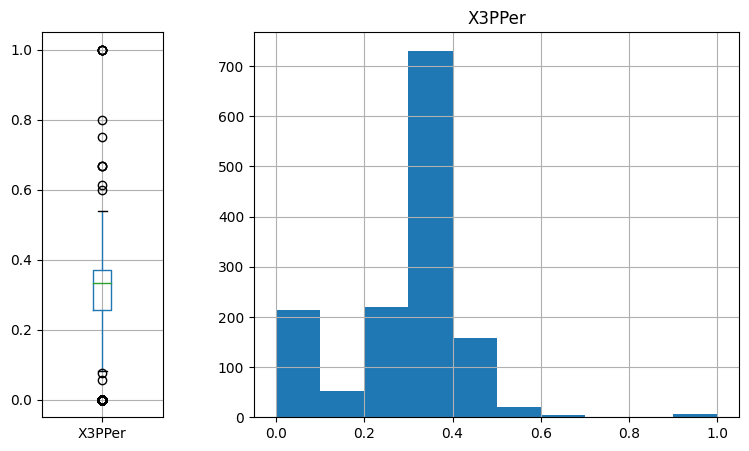

In [ ]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
dataset.boxplot(column='X3PPer',ax=axes[0]);
dataset.hist(column='X3PPer', ax=axes[1]);

Observant l'histograma, hem decidit eliminar el valor que és igual a 1 perquè és gairebé impossible a la realitat que un jugador faci un 100% en triples.

In [ ]:
rows_to_remove = dataset[dataset['X3PPer'] ==1].index
dataset.drop(rows_to_remove, inplace=True)

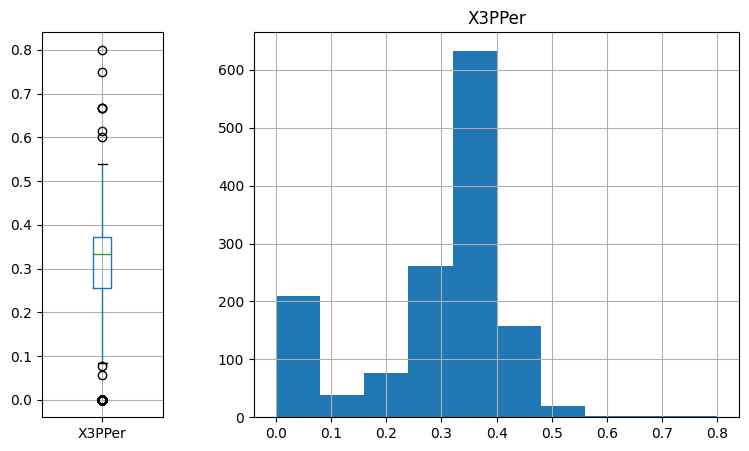

In [ ]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
dataset.boxplot(column='X3PPer',ax=axes[0]);
dataset.hist(column='X3PPer', ax=axes[1]);

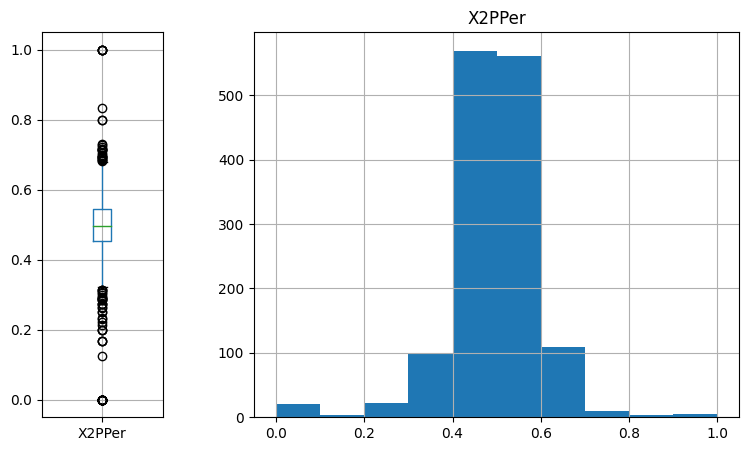

In [ ]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
dataset.boxplot(column='X2PPer',ax=axes[0]);
dataset.hist(column='X2PPer', ax=axes[1]);

In [ ]:
rows_to_remove = dataset[dataset['X2PPer'] ==1].index
dataset.drop(rows_to_remove, inplace=True)

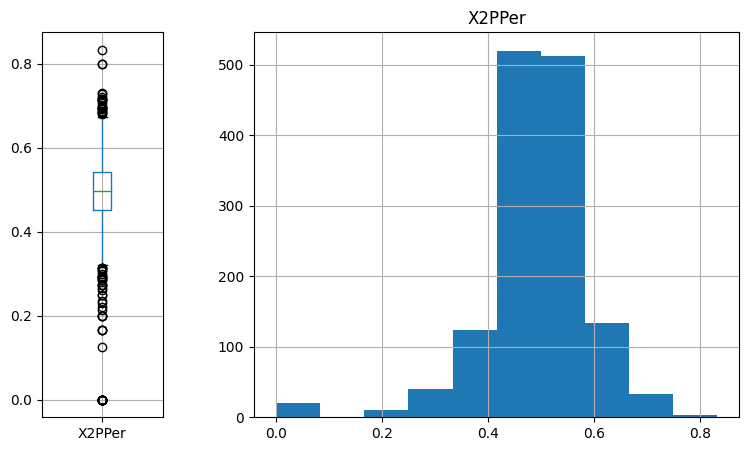

In [ ]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
dataset.boxplot(column='X2PPer',ax=axes[0]);
dataset.hist(column='X2PPer', ax=axes[1]);

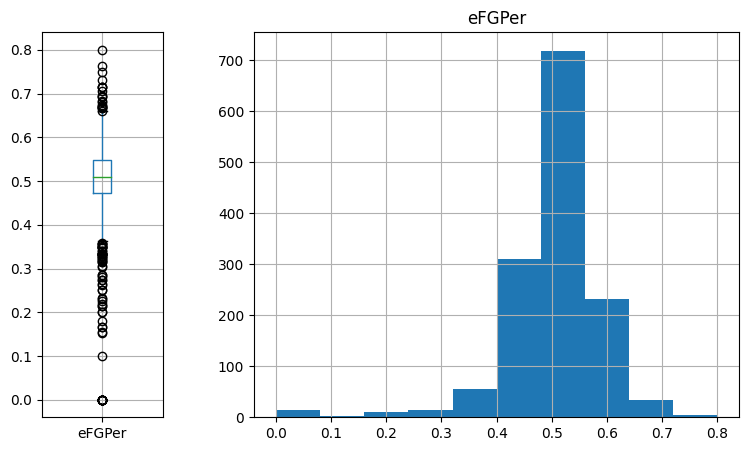

In [ ]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
dataset.boxplot(column='eFGPer',ax=axes[0]);
dataset.hist(column='eFGPer', ax=axes[1]);

Veiem un outlier molt clar, ja que té un valor de eFG% de 1.5, que és el màxim possible, ja que la fórmula d'aquesta variable és:
(Tirs de camp anotats + 0.5 x Triples anotats) / Tirs de camp intentats.


In [ ]:
rows_to_remove = dataset[dataset['eFGPer'] > 1].index
dataset.drop(rows_to_remove, inplace=True)


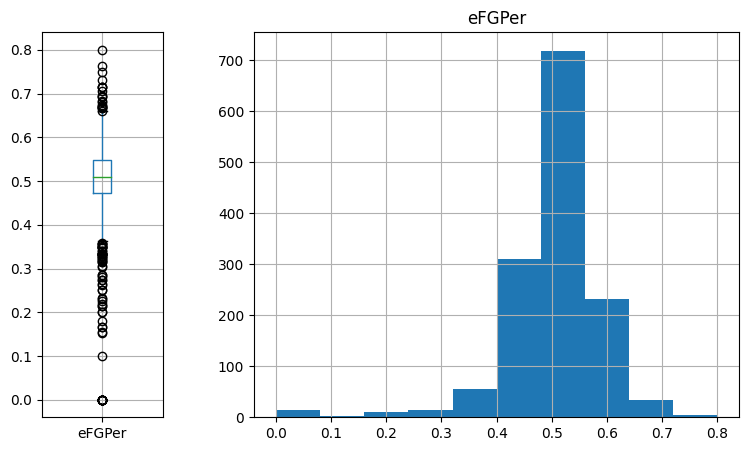

In [ ]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
dataset.boxplot(column='eFGPer',ax=axes[0]);
dataset.hist(column='eFGPer', ax=axes[1]);

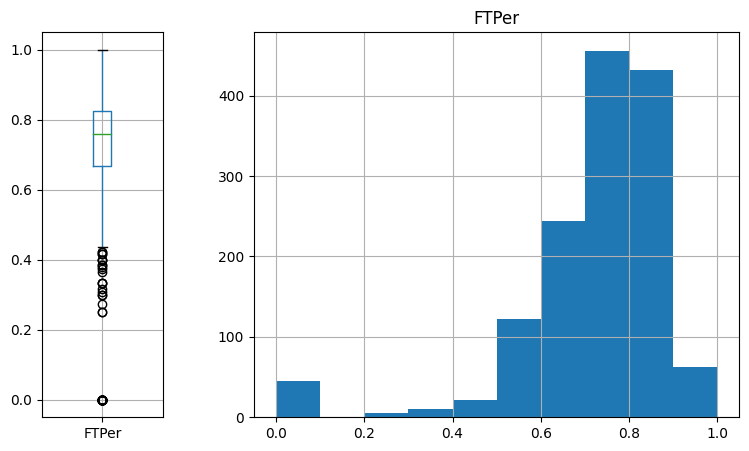

In [ ]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
dataset.boxplot(column='FTPer',ax=axes[0]);
dataset.hist(column='FTPer', ax=axes[1]);

En aquest cas, veiem que els outliers son els valors més baixos.
L'únic valor que hem pensat eliminar és el 0, però com que anteriorment hem decidit imputar aquest valor als que tenien valor nul, decidim no eliminar aquestes files.

NORMALITZACIÓ DE LES DADES

Al següent pas passarem a normalitzar les dades, un pas important per tal d'assegurar que tots els atributs estan en una escala similar.


In [ ]:
# initiate the MinMaxScaler
scaler = MinMaxScaler()

# fit and transform the data from the continuous subset
normalized_data = scaler.fit_transform(subset_continuous)
normalized_subsetcont = pd.DataFrame(normalized_data, columns=subset_continuous.columns)
normalized_subsetcont[:4]

,Age,G,GS,MP,FG,FGA,FGPer,X3P,X3PA,X3PPer,X2P,X2PA,X2PPer,eFGPer,FT,FTA,FTPer,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary,mean_views,Fvot,FRank,Pvot,PRank,Mvot,MRank,Score
0,0.217391,0.259259,0.000000,0.180593,0.074074,0.077551,0.405,0.039216,0.037879,0.500,0.051546,0.078125,0.375,0.309333,0.041237,0.081818,0.450,0.074074,0.117117,0.10000,0.017857,0.000000,0.222222,0.087719,0.25,0.060942,0.031960,0.000064,0.000169,0.847222,0.000000,0.000000,0.0,0.0,0.497587
1,0.565217,0.790123,0.000000,0.353100,0.175926,0.187755,0.403,0.137255,0.151515,0.375,0.113402,0.135417,0.424,0.322000,0.051546,0.054545,0.800,0.055556,0.072072,0.06875,0.169643,0.166667,0.037037,0.175439,0.35,0.138504,0.070672,0.000293,0.000535,0.437500,0.000000,0.000000,0.0,0.0,0.284680
2,0.086957,0.975309,0.878049,0.754717,0.453704,0.440816,0.454,0.196078,0.250000,0.288,0.412371,0.390625,0.528,0.332667,0.206186,0.245455,0.719,0.277778,0.324324,0.31875,0.169643,0.333333,0.185185,0.192982,0.55,0.351801,0.114825,0.050161,0.004928,0.194444,0.000000,0.000000,0.0,0.0,0.235223
3,0.260870,0.209877,0.000000,0.183288,0.120370,0.122449,0.426,0.039216,0.060606,0.200,0.113402,0.114583,0.513,0.302667,0.082474,0.100000,0.737,0.092593,0.117117,0.11250,0.035714,0.166667,0.148148,0.070175,0.45,0.096953,0.052550,0.005995,0.000186,0.826389,0.003717,0.590909,0.0,0.0,0.449337


In [ ]:
dataset = pd.concat([subset_cathegorics, normalized_subsetcont, subset_target], axis=1)
dataset[:4]

,ATL,BOS,BRK,CHI,CHO,CLE,DAL,DEN,DET,GSW,HOU,IND,LAC,LAL,MEM,MIA,MIL,MIN,NOP,NYK,OKC,ORL,PHI,PHO,POR,SAC,SAS,TOR,UTA,WAS,2016-17,2017-18,2018-19,Back,Front,C,PF,PG,SF,SG,Est,West,Age,G,GS,MP,FG,FGA,FGPer,X3P,X3PA,X3PPer,X2P,X2PA,X2PPer,eFGPer,FT,FTA,FTPer,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary,mean_views,Fvot,FRank,Pvot,PRank,Mvot,MRank,Score,Play
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.217391,0.259259,0.000000,0.180593,0.074074,0.077551,0.405,0.039216,0.037879,0.500,0.051546,0.078125,0.375,0.309333,0.041237,0.081818,0.450,0.074074,0.117117,0.10000,0.017857,0.000000,0.222222,0.087719,0.25,0.060942,0.031960,0.000064,0.000169,0.847222,0.000000,0.000000,0.0,0.0,0.497587,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.565217,0.790123,0.000000,0.353100,0.175926,0.187755,0.403,0.137255,0.151515,0.375,0.113402,0.135417,0.424,0.322000,0.051546,0.054545,0.800,0.055556,0.072072,0.06875,0.169643,0.166667,0.037037,0.175439,0.35,0.138504,0.070672,0.000293,0.000535,0.437500,0.000000,0.000000,0.0,0.0,0.284680,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.086957,0.975309,0.878049,0.754717,0.453704,0.440816,0.454,0.196078,0.250000,0.288,0.412371,0.390625,0.528,0.332667,0.206186,0.245455,0.719,0.277778,0.324324,0.31875,0.169643,0.333333,0.185185,0.192982,0.55,0.351801,0.114825,0.050161,0.004928,0.194444,0.000000,0.000000,0.0,0.0,0.235223,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.260870,0.209877,0.000000,0.183288,0.120370,0.122449,0.426,0.039216,0.060606,0.200,0.113402,0.114583,0.513,0.302667,0.082474,0.100000,0.737,0.092593,0.117117,0.11250,0.035714,0.166667,0.148148,0.070175,0.45,0.096953,0.052550,0.005995,0.000186,0.826389,0.003717,0.590909,0.0,0.0,0.449337,0.0


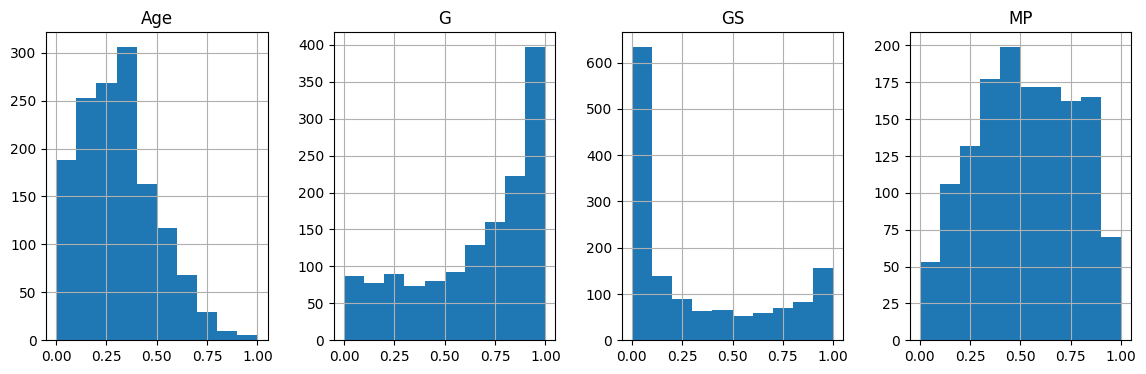

In [ ]:
normalized_subsetcont[['Age','G', 'GS', 'MP']].hist(figsize=(14,4), layout=(1,4));

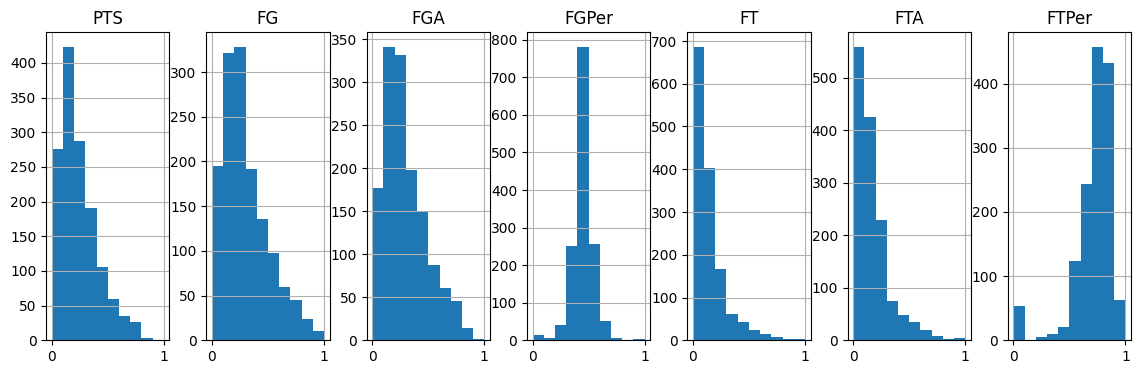

In [ ]:
normalized_subsetcont[['PTS', 'FG','FGA', 'FGPer', 'FT', 'FTA', 'FTPer']].hist(figsize=(14,4), layout=(1,7));

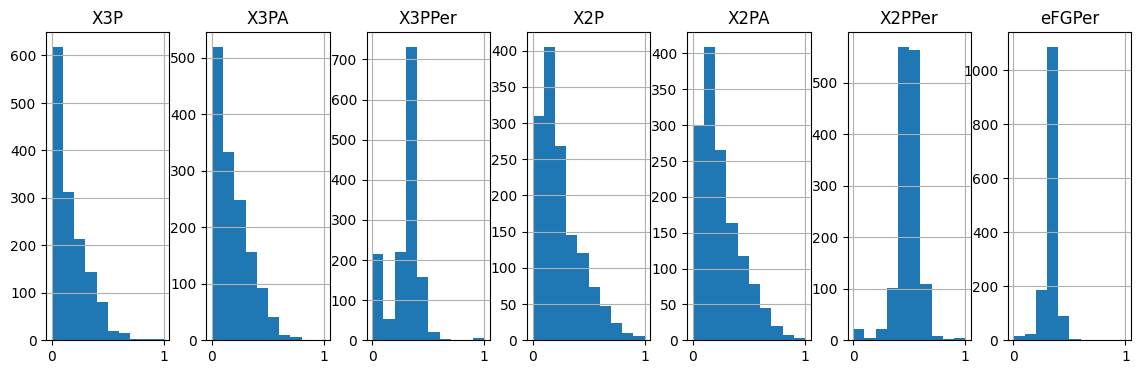

In [ ]:
normalized_subsetcont[['X3P','X3PA', 'X3PPer', 'X2P', 'X2PA', 'X2PPer', 'eFGPer']].hist(figsize=(14,4), layout=(1,7));

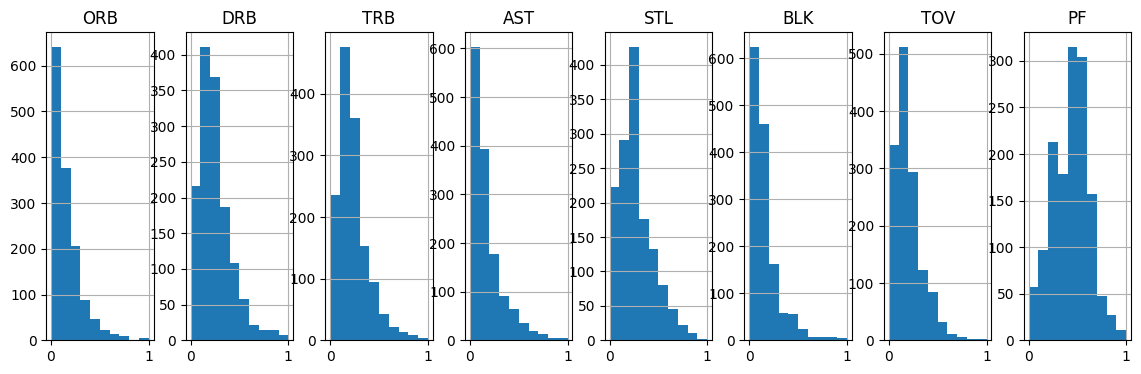

In [ ]:
normalized_subsetcont[['ORB','DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']].hist(figsize=(14,4), layout=(1,8));

Ara podem separar el dataset en temporades, per a fer-ho, ens fixarem en l'atribut Season, que indica la temporada a la qual pertanyen les estadístiques d'aquest jugador.

In [ ]:
dataset_16_17=dataset[dataset['2016-17'] == True]
print(dataset_16_17.shape)
dataset_17_18=dataset[dataset['2017-18'] == True]
print(dataset_17_18.shape)
dataset_18_19=dataset[dataset['2018-19'] == True]
print(dataset_18_19.shape)

(436, 78)
(498, 78)
(474, 78)


##MODELATGE

RESAMPLING:

Ara separem cadascun dels datasets de cada any per a fer training i validació, ho haurem de fer per a cada temporada.

In [ ]:
np.random.seed(123) # for reproducibility
dataset[:4]

,ATL,BOS,BRK,CHI,CHO,CLE,DAL,DEN,DET,GSW,HOU,IND,LAC,LAL,MEM,MIA,MIL,MIN,NOP,NYK,OKC,ORL,PHI,PHO,POR,SAC,SAS,TOR,UTA,WAS,2016-17,2017-18,2018-19,Back,Front,C,PF,PG,SF,SG,Est,West,Age,G,GS,MP,FG,FGA,FGPer,X3P,X3PA,X3PPer,X2P,X2PA,X2PPer,eFGPer,FT,FTA,FTPer,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary,mean_views,Fvot,FRank,Pvot,PRank,Mvot,MRank,Score,Play
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.217391,0.259259,0.000000,0.180593,0.074074,0.077551,0.405,0.039216,0.037879,0.500,0.051546,0.078125,0.375,0.309333,0.041237,0.081818,0.450,0.074074,0.117117,0.10000,0.017857,0.000000,0.222222,0.087719,0.25,0.060942,0.031960,0.000064,0.000169,0.847222,0.000000,0.000000,0.0,0.0,0.497587,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.565217,0.790123,0.000000,0.353100,0.175926,0.187755,0.403,0.137255,0.151515,0.375,0.113402,0.135417,0.424,0.322000,0.051546,0.054545,0.800,0.055556,0.072072,0.06875,0.169643,0.166667,0.037037,0.175439,0.35,0.138504,0.070672,0.000293,0.000535,0.437500,0.000000,0.000000,0.0,0.0,0.284680,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.086957,0.975309,0.878049,0.754717,0.453704,0.440816,0.454,0.196078,0.250000,0.288,0.412371,0.390625,0.528,0.332667,0.206186,0.245455,0.719,0.277778,0.324324,0.31875,0.169643,0.333333,0.185185,0.192982,0.55,0.351801,0.114825,0.050161,0.004928,0.194444,0.000000,0.000000,0.0,0.0,0.235223,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.260870,0.209877,0.000000,0.183288,0.120370,0.122449,0.426,0.039216,0.060606,0.200,0.113402,0.114583,0.513,0.302667,0.082474,0.100000,0.737,0.092593,0.117117,0.11250,0.035714,0.166667,0.148148,0.070175,0.45,0.096953,0.052550,0.005995,0.000186,0.826389,0.003717,0.590909,0.0,0.0,0.449337,0.0


In [ ]:
dat_16_17_X1=dataset_16_17.iloc[:,0:30]
dat_16_17_X2=dataset_16_17.iloc[:,33:70]
dat_16_17_X=pd.concat([dat_16_17_X1,dat_16_17_X2],axis=1)


dat_16_17_Y=dataset_16_17.loc[:,['Play']]

In [ ]:
dat_17_18_X1=dataset_17_18.iloc[:,0:30]
dat_17_18_X2=dataset_17_18.iloc[:,33:70]
dat_17_18_X=pd.concat([dat_17_18_X1,dat_17_18_X2],axis=1)


dat_17_18_Y=dataset_17_18.loc[:,['Play']]


In [ ]:
dat_18_19_X1=dataset_18_19.iloc[:,0:30]
dat_18_19_X2=dataset_18_19.iloc[:,33:70]
dat_18_19_X=pd.concat([dat_18_19_X1,dat_18_19_X2],axis=1)


dat_18_19_Y=dataset_18_19.loc[:,['Play']]

In [ ]:
#Train-test split
dat_16_17_X_train,dat_16_17_X_test,dat_16_17_Y_train,dat_16_17_Y_test=train_test_split(dat_16_17_X,dat_16_17_Y,test_size=0.25,stratify=dat_16_17_Y, random_state=123)
dat_17_18_X_train,dat_17_18_X_test,dat_17_18_Y_train,dat_17_18_Y_test=train_test_split(dat_17_18_X,dat_17_18_Y,test_size=0.25,stratify=dat_17_18_Y, random_state=123)
dat_18_19_X_train,dat_18_19_X_test,dat_18_19_Y_train,dat_18_19_Y_test=train_test_split(dat_18_19_X,dat_18_19_Y,test_size=0.25,stratify=dat_18_19_Y, random_state=123)

#Train-validation split
dat_16_17_X_train2,dat_16_17_X_val,dat_16_17_Y_train2,dat_16_17_Y_val=train_test_split(dat_16_17_X_train,dat_16_17_Y_train,test_size=0.25,stratify=dat_16_17_Y_train, random_state=123)
dat_17_18_X_train2,dat_17_18_X_val,dat_17_18_Y_train2,dat_17_18_Y_val=train_test_split(dat_17_18_X_train,dat_17_18_Y_train,test_size=0.25,stratify=dat_17_18_Y_train, random_state=123)
dat_18_19_X_train2,dat_18_19_X_val,dat_18_19_Y_train2,dat_18_19_Y_val=train_test_split(dat_18_19_X_train,dat_18_19_Y_train,test_size=0.25,stratify=dat_18_19_Y_train, random_state=123)

Ara crearem un dataframe que guardi els resultats de cada métode:

In [ ]:
results_df = pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

QDA

Primer de tot, decidirem quin hiperparámetre dona millors resultats per al nostre cas.

In [ ]:
def compute_metrics(y_real,y_pred):
    # Per defecte, calcularà la sensibilitat binària de la classe 1, podem especificar quina classe volem utilitzant aquest paràmetre
    recall_class_1 =recall_score(y_real,y_pred, pos_label=1)
    f1_class_1 =f1_score(y_real,y_pred, pos_label=1)
    accuracy = accuracy_score(y_real,y_pred)
    f1_macro =f1_score(y_real,y_pred, average='macro')
    precison_macro =precision_score(y_real,y_pred,  average='macro')
    recall_macro =recall_score(y_real,y_pred,  average='macro')
    return [recall_class_1, f1_class_1, accuracy,f1_macro,precison_macro,recall_macro ]

In [ ]:
index= pd.MultiIndex.from_arrays([[], []], names=('model', 'reg'));
results_qda = pd.DataFrame(index=index, columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro']);

regularization_parameters = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1];

for reg in regularization_parameters:
    qda_model = QuadraticDiscriminantAnalysis(reg_param=reg);
    qda_model = qda_model.fit(dat_16_17_X_train2,dat_16_17_Y_train2);
    y_pred = qda_model.predict(dat_16_17_X_val);
    results_qda.loc[('QDA',reg), :] = compute_metrics(dat_16_17_Y_val, y_pred);

results_qda.sort_values(by='**Recall class 1**', ascending=False)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/py

**Recall class 1** **F1 class 1**  Accuracy  F1 Macro  \
model reg                                                            
QDA   0.0000                0.0            0.0  0.939024  0.484277   
      0.0001                0.0            0.0  0.939024  0.484277   
      0.0010                0.0            0.0  0.939024  0.484277   
      0.0100                0.0            0.0  0.939024  0.484277   
      0.1000                0.0            0.0  0.939024  0.484277   
      0.5000                0.0            0.0  0.939024  0.484277   
      1.0000                0.0            0.0  0.939024  0.484277   

             Precision Macro Recall Macro  
model reg                                  
QDA   0.0000        0.469512          0.5  
      0.0001        0.469512          0.5  
      0.0010        0.469512          0.5  
      0.0100        0.469512          0.5  
      0.1000        0.469512          0.5  
      0.5000        0.469512          0.5  
      1.0000        0.469512          0.5

Veient que el valor no afecta, així que arbitràriament escollim 1.

In [ ]:
qda_model = QuadraticDiscriminantAnalysis(reg_param=1).fit(dat_16_17_X_train2, dat_16_17_Y_train2)

print('Priors:', qda_model.priors_)
print('Means:\n')
means =pd.DataFrame(qda_model.means_)
means.columns=dat_16_17_X_train2.columns[0:]
means

Priors: [0.94693878 0.05306122]
Means:



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,ATL,BOS,BRK,CHI,CHO,CLE,DAL,DEN,DET,GSW,HOU,IND,LAC,LAL,MEM,MIA,MIL,MIN,NOP,NYK,OKC,ORL,PHI,PHO,POR,SAC,SAS,TOR,UTA,WAS,Back,Front,C,PF,PG,SF,SG,Est,West,Age,G,GS,MP,FG,FGA,FGPer,X3P,X3PA,X3PPer,X2P,X2PA,X2PPer,eFGPer,FT,FTA,FTPer,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary,mean_views
0,0.021552,0.021552,0.047414,0.021552,0.025862,0.038793,0.038793,0.034483,0.025862,0.021552,0.025862,0.025862,0.030172,0.025862,0.043103,0.043103,0.030172,0.038793,0.030172,0.034483,0.030172,0.038793,0.030172,0.047414,0.030172,0.034483,0.043103,0.034483,0.034483,0.051724,0.392241,0.607759,0.219828,0.254310,0.176724,0.137931,0.211207,0.482759,0.517241,0.312031,0.691943,0.300410,0.512164,0.280452,0.273364,0.450504,0.140044,0.153540,0.278690,0.238580,0.243422,0.485341,0.333977,0.134332,0.155721,0.71994,0.166746,0.245961,0.226886,0.148553,0.251796,0.151820,0.185345,0.429741,0.223636,0.150611,0.014449
1,0.076923,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.153846,0.076923,0.000000,0.076923,0.000000,0.076923,0.000000,0.076923,0.000000,0.153846,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.076923,0.000000,0.000000,0.230769,0.769231,0.307692,0.153846,0.153846,0.307692,0.076923,0.384615,0.615385,0.374582,0.921178,0.920263,0.912088,0.731481,0.672527,0.488615,0.300151,0.327506,0.312692,0.656622,0.633013,0.531077,0.355949,0.544806,0.611888,0.77800,0.280627,0.594595,0.506731,0.449176,0.554487,0.381766,0.495277,0.626923,0.627317,0.526974,0.181573


In [ ]:
y_pred = qda_model.predict(dat_16_17_X_val)
cm = confusion_matrix(dat_16_17_Y_val, y_pred)
print(cm) 

[[77  0]
 [ 5  0]]


No prediu cap jugdor de la particio de train ni de la de validació com a all-star, cosa que ens pot indicar que no és un bon resultat, provarem ara d'utilitzar amb crossvalidation:

In [ ]:
cross_val_results = pd.DataFrame(cross_validate(qda_model , dat_16_17_X_train, dat_16_17_Y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

results_df.loc['QDA',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labe

,Accuracy,F1 Macro,Precision Macro,Recall Macro
QDA,0.948019,0.526614,0.573939,0.525


LOGISTIC REGRESSION

In [ ]:
logreg = LogisticRegressionCV(Cs=20, random_state=123, cv = 5, scoring = 'accuracy', multi_class='multinomial')
logreg.fit(dat_16_17_X_train2,dat_16_17_Y_train2) 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV(Cs=20, cv=5, multi_class='multinomial', random_state=123,
                     scoring='accuracy')

In [ ]:
# Per trobar la 'C' òptima

avg_crossval_scores = logreg.predict_proba(dat_16_17_X_train2)[:, 1].mean()
idx = np.argmax(avg_crossval_scores)
best_C = logreg.Cs_[idx]
print(best_C)

0.0001


In [ ]:
logreg = LogisticRegression(C=best_C, multi_class='multinomial')
logreg.fit(dat_16_17_X_train2,dat_16_17_Y_train2)
cross_val_results = pd.DataFrame(cross_validate(logreg, dat_16_17_X_train2,dat_16_17_Y_train2, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Logistic Regression',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

In [ ]:
y_pred = logreg.predict(dat_16_17_X_val)
cm = confusion_matrix(dat_16_17_Y_val, y_pred)
print(cm) 

[[77  0]
 [ 5  0]]


In [ ]:
results_df.sort_values(by='Accuracy', ascending=False)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
QDA,0.948019,0.526614,0.573939,0.525
Logistic Regression,0.946939,0.48636,0.473469,0.5


GAUSSIAN NAIVE BAYES

In [ ]:
gaussian_nb = GaussianNB()

gaussian_nb.fit(dat_16_17_X_train2,dat_16_17_Y_train2)

cross_val_results = pd.DataFrame(cross_validate(gaussian_nb , dat_16_17_X_train2, dat_16_17_Y_train2, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

results_df.loc['GaussianNB',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [ ]:
y_pred = gaussian_nb.predict(dat_16_17_X_val)
cm = confusion_matrix(dat_16_17_Y_val, y_pred)
print(cm) 

[[65 12]
 [ 3  2]]


In [ ]:
results_df.sort_values(by='F1 Macro', ascending=False)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
QDA,0.948019,0.526614,0.573939,0.525
GaussianNB,0.857143,0.525784,0.522377,0.562874
Logistic Regression,0.946939,0.48636,0.473469,0.5


K-NN:

In [ ]:
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(
    estimator=knn,
    param_grid={
        'n_neighbors': [1, 3, 5, 7, 10, 15, 20],
        'metric': ['euclidean', 'minkowski', 'manhattan']
    },
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    refit=False
)

knn_cv.fit(dat_16_17_X_train,dat_16_17_Y_train)
results_cv = pd.DataFrame(knn_cv.cv_results_)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame

In [ ]:
cols = ['param_n_neighbors', 'param_metric',
     'mean_test_accuracy',
    'mean_test_f1_macro', 'mean_test_precision_macro',
    'mean_test_recall_macro', 
    'std_test_accuracy', 'std_test_f1_macro', 'std_test_precision_macro',
    'std_test_recall_macro'
]
results_cv[cols].sort_values(by='mean_test_f1_macro',ascending=False)

,param_n_neighbors,param_metric,mean_test_accuracy,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro,std_test_accuracy,std_test_f1_macro,std_test_precision_macro,std_test_recall_macro
14,1,manhattan,0.972354,0.785669,0.854113,0.756694,0.017974,0.176508,0.200457,0.171705
0,1,euclidean,0.969324,0.773744,0.834113,0.755081,0.013865,0.163133,0.189599,0.169435
7,1,minkowski,0.969324,0.773744,0.834113,0.755081,0.013865,0.163133,0.189599,0.169435
1,3,euclidean,0.963263,0.709364,0.862957,0.681720,0.012287,0.144403,0.195464,0.164874
15,3,manhattan,0.963263,0.709364,0.862957,0.681720,0.012287,0.144403,0.195464,0.164874
8,3,minkowski,0.963263,0.709364,0.862957,0.681720,0.012287,0.144403,0.195464,0.164874
2,5,euclidean,0.963263,0.706203,0.881369,0.658333,0.012287,0.139396,0.202303,0.121906
16,5,manhattan,0.963263,0.706203,0.881369,0.658333,0.012287,0.139396,0.202303,0.121906
9,5,minkowski,0.963263,0.706203,0.881369,0.658333,0.012287,0.139396,0.202303,0.121906
17,7,manhattan,0.954079,0.594818,0.676875,0.575000,0.009881,0.139195,0.248058,0.100000


Sembla que el millor paràmetre que podem agafar per a k és 1, i la millor distància és manhattan

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
knn.fit(dat_16_17_X_train2, dat_16_17_Y_train2)

y_pred = knn.predict(dat_16_17_X_val)
cm = confusion_matrix(dat_16_17_Y_val, y_pred)
print(cm) 

[[77  0]
 [ 4  1]]


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
knn.fit(dat_16_17_X_train, dat_16_17_Y_train)

cross_val_results = pd.DataFrame(cross_validate(knn , dat_16_17_X_train, dat_16_17_Y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

results_df.loc['KNN',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

,Accuracy,F1 Macro,Precision Macro,Recall Macro
QDA,0.948019,0.526614,0.573939,0.525
Logistic Regression,0.946939,0.48636,0.473469,0.5
GaussianNB,0.857143,0.525784,0.522377,0.562874
KNN,0.972354,0.785669,0.854113,0.756694


DECISION TREES


In [ ]:
model_tree = DecisionTreeClassifier(random_state=42).fit(dat_16_17_X_train2, dat_16_17_Y_train2)

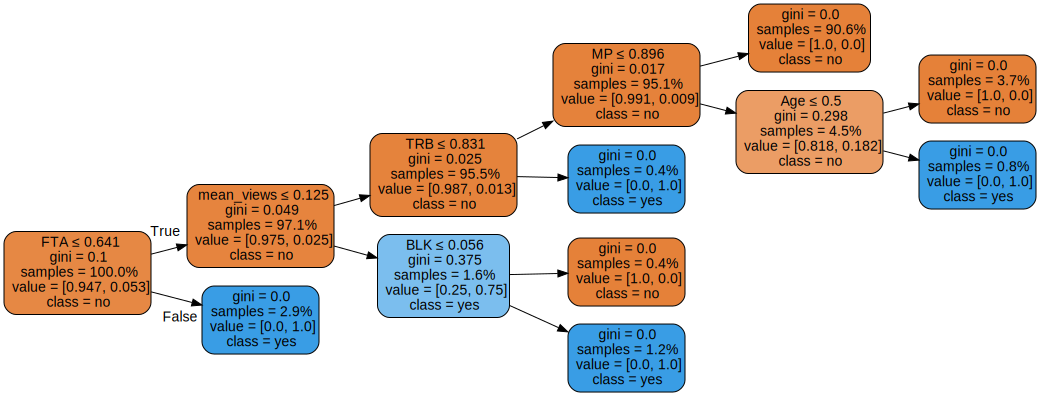

In [ ]:
dot_data = export_graphviz(model_tree, out_file=None, 
                         feature_names=dat_16_17_X_train.columns,  
                         class_names=['no', 'yes'],  
                         filled=True, rounded=True,  
                         special_characters=True, 
                         rotate=True,
                         proportion=True,
                         max_depth=5)  
graph = graphviz.Source(dot_data)  
graph 

In [ ]:
def compute_metrics(y_real,y_pred):
    # Per defecte, calcularà la sensibilitat binària de la classe 1, podem especificar quina classe volem utilitzant aquest paràmetre
    recall_class_1 =recall_score(y_real,y_pred, pos_label=1)
    f1_class_1 =f1_score(y_real,y_pred, pos_label=1)
    accuracy = accuracy_score(y_real,y_pred)
    f1_macro =f1_score(y_real,y_pred, average='macro')
    precison_macro =precision_score(y_real,y_pred,  average='macro')
    recall_macro =recall_score(y_real,y_pred,  average='macro')
    return [accuracy,f1_macro,precison_macro,recall_macro ]
    

In [ ]:
y_pred = model_tree.predict(dat_16_17_X_val)

results_df.loc['DT-default',:] = compute_metrics(dat_16_17_Y_val, y_pred)

confusion_matrix(dat_16_17_Y_val, y_pred)

array([[73,  4],
       [ 3,  2]])

In [ ]:
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
QDA,0.948019,0.526614,0.573939,0.525
Logistic Regression,0.946939,0.48636,0.473469,0.5
GaussianNB,0.857143,0.525784,0.522377,0.562874
KNN,0.972354,0.785669,0.854113,0.756694
DT-default,0.914634,0.658942,0.64693,0.674026


In [ ]:
print(classification_report(dat_16_17_Y_val, y_pred, target_names=['no', 'yes'],))

              precision    recall  f1-score   support

          no       0.96      0.95      0.95        77
         yes       0.33      0.40      0.36         5

    accuracy                           0.91        82
   macro avg       0.65      0.67      0.66        82
weighted avg       0.92      0.91      0.92        82



In [ ]:
print('Tree depht: {}\nNodes: {}'.format(model_tree.tree_.max_depth, model_tree.tree_.node_count))

Tree depht: 5
Nodes: 13


Podem destacar que el nostre model té molt poca profunditat.

In [ ]:
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
QDA,0.948019,0.526614,0.573939,0.525
Logistic Regression,0.946939,0.48636,0.473469,0.5
GaussianNB,0.857143,0.525784,0.522377,0.562874
KNN,0.972354,0.785669,0.854113,0.756694
DT-default,0.914634,0.658942,0.64693,0.674026


In [ ]:
criterion = ['gini', 'entropy']

max_dephts = [None, 5, 10, 15, 20]
min_samples_split = [1, 2, 3, 4, 5]
min_samples_leaf = [1, 2, 3, 4, 5]
max_features = ['auto', 'sqrt', 'log2', None]

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

model_tree = DecisionTreeClassifier(random_state=33)

f1_class_0_scorer = make_scorer(f1_score, pos_label=0)
f1_class_1_scorer = make_scorer(f1_score, pos_label=1)

scoring_dict = {
    'f1_mac': 'f1_macro',
    'f1_class_0': f1_class_0_scorer,
    'f1_class_1': f1_class_1_scorer,
    'acc': 'accuracy'
}

trc = GridSearchCV(estimator=model_tree,
                   scoring=scoring_dict,
                   param_grid={
                       'criterion': criterion,
                       'max_depth': max_dephts,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'max_features': max_features
                   },
                   cv=5,
                   return_train_score=False,
                   refit='f1_mac')

model_5CV = trc.fit(dat_16_17_X_train2, dat_16_17_Y_train2)

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

In [ ]:
scoring_cols = [
    'param_criterion', 'param_max_depth', 'param_max_features',
    'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_f1_mac',
    'mean_test_f1_class_0', 'mean_test_f1_class_1', 'mean_test_acc'
]

pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc
28,gini,None,sqrt,1,4,0.758427,0.964631,0.552222,0.934694
429,gini,20,sqrt,1,5,0.758427,0.964631,0.552222,0.934694
228,gini,10,sqrt,1,4,0.758427,0.964631,0.552222,0.934694
403,gini,20,auto,1,4,0.758427,0.964631,0.552222,0.934694
404,gini,20,auto,1,5,0.758427,0.964631,0.552222,0.934694


In [ ]:
best_params = model_5CV.best_params_
best_params

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 4}

In [ ]:
y_pred = model_5CV.predict(dat_16_17_X_val)

results_df.loc['DT-best',:] = compute_metrics(dat_16_17_Y_val, y_pred)

confusion_matrix(dat_16_17_Y_val,y_pred)

array([[73,  4],
       [ 3,  2]])

In [ ]:
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
QDA,0.948019,0.526614,0.573939,0.525
Logistic Regression,0.946939,0.48636,0.473469,0.5
GaussianNB,0.857143,0.525784,0.522377,0.562874
KNN,0.972354,0.785669,0.854113,0.756694
DT-default,0.914634,0.658942,0.64693,0.674026
DT-best,0.914634,0.658942,0.64693,0.674026


RANDOM FORESTS

In [ ]:
model_rf1 = RandomForestClassifier(oob_score=True,random_state=100).fit(dat_16_17_X_train2,dat_16_17_Y_train2)

pred = model_rf1.predict(dat_16_17_X_train2)

cm = confusion_matrix(dat_16_17_Y_train2, pred)
print(cm) 

print(classification_report(dat_16_17_Y_train2, pred, target_names=['no', 'yes'],))

print('OOB accuracy=', model_rf1.oob_score_)

<ipython-input-82-aba1de33462f>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf1 = RandomForestClassifier(oob_score=True,random_state=100).fit(dat_16_17_X_train2,dat_16_17_Y_train2)


[[232   0]
 [  0  13]]
              precision    recall  f1-score   support

          no       1.00      1.00      1.00       232
         yes       1.00      1.00      1.00        13

    accuracy                           1.00       245
   macro avg       1.00      1.00      1.00       245
weighted avg       1.00      1.00      1.00       245

OOB accuracy= 0.9673469387755103


In [ ]:
y_pred = model_rf1.predict(dat_16_17_X_val)
print('Validation Accuracy:{}'.format(model_rf1.score(dat_16_17_X_val,dat_16_17_Y_val)))
results_df.loc['RF-default',:] = compute_metrics(dat_16_17_Y_val,y_pred)
confusion_matrix(dat_16_17_Y_val,y_pred)

Validation Accuracy:0.9390243902439024


array([[75,  2],
       [ 3,  2]])

In [ ]:
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
QDA,0.948019,0.526614,0.573939,0.525
Logistic Regression,0.946939,0.48636,0.473469,0.5
GaussianNB,0.857143,0.525784,0.522377,0.562874
KNN,0.972354,0.785669,0.854113,0.756694
DT-default,0.914634,0.658942,0.64693,0.674026
DT-best,0.914634,0.658942,0.64693,0.674026
RF-default,0.939024,0.706093,0.730769,0.687013


In [ ]:
model_rf2 = RandomForestClassifier(n_estimators=100, 
                                   oob_score=True, 
                                   class_weight='balanced').fit(dat_16_17_X_train2,dat_16_17_Y_train2)

pred = model_rf2.predict(dat_16_17_X_train2)

cm = confusion_matrix(dat_16_17_Y_train2, pred)
print(cm)

print(classification_report(dat_16_17_Y_train2,pred,target_names=['no', 'yes'],))

print('OOB accuracy=', model_rf2.oob_score_) # Menor accuracy si apliquem un balance

<ipython-input-85-5dbaddc24ac9>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  class_weight='balanced').fit(dat_16_17_X_train2,dat_16_17_Y_train2)


[[232   0]
 [  0  13]]
              precision    recall  f1-score   support

          no       1.00      1.00      1.00       232
         yes       1.00      1.00      1.00        13

    accuracy                           1.00       245
   macro avg       1.00      1.00      1.00       245
weighted avg       1.00      1.00      1.00       245

OOB accuracy= 0.963265306122449


In [ ]:
y_pred = model_rf2.predict(dat_16_17_X_val)

results_df.loc['RF-balance',:] = compute_metrics(dat_16_17_Y_val,y_pred)

confusion_matrix(dat_16_17_Y_val,y_pred)

array([[75,  2],
       [ 4,  1]])

In [ ]:
results_df.sort_values(by='F1 Macro', ascending=False)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN,0.972354,0.785669,0.854113,0.756694
RF-default,0.939024,0.706093,0.730769,0.687013
DT-default,0.914634,0.658942,0.64693,0.674026
DT-best,0.914634,0.658942,0.64693,0.674026
RF-balance,0.926829,0.605769,0.64135,0.587013
QDA,0.948019,0.526614,0.573939,0.525
GaussianNB,0.857143,0.525784,0.522377,0.562874
Logistic Regression,0.946939,0.48636,0.473469,0.5


In [ ]:
rf_model = RandomForestClassifier()

ntrees = [200,None]
max_depth = [100,None]
min_samples_split = [4,6]
min_samples_leaf = [4,6]
balance = [None, 'balanced', 'balanced_subsample']

trc = GridSearchCV(estimator=rf_model,
                   scoring=scoring_dict,
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth':max_depth,
                       'min_samples_split':min_samples_split,
                       'min_samples_leaf':min_samples_leaf, 
                       'class_weight':balance
                   },
                   cv=5,
                   return_train_score=False,
                   refit=False,
                   n_jobs=-1)

model_5CV = trc.fit(dat_16_17_X_train2, dat_16_17_Y_train2)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ut

In [ ]:
scoring_cols = [
    'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split',
    'mean_test_f1_mac', 'mean_test_f1_class_0', 'mean_test_f1_class_1',
    'mean_test_acc'
]
pd.DataFrame(model_5CV.cv_results_).sort_values(
    by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc
16,100,4,4,0.819184,0.985035,0.653333,0.971429
40,None,4,4,0.819184,0.985035,0.653333,0.971429
32,100,4,4,0.819184,0.985035,0.653333,0.971429
18,100,4,6,0.819184,0.985035,0.653333,0.971429
24,None,4,4,0.804752,0.982838,0.626667,0.967347


In [ ]:
best_params = pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params

{'class_weight': 'balanced',
 'max_depth': 100,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 200}

In [ ]:
rf_model_tuned = RandomForestClassifier(**best_params,random_state=123)
rf_model_tuned.fit(dat_16_17_X_train2, dat_16_17_Y_train2)

y_pred = rf_model_tuned.predict(dat_16_17_X_val)

results_df.loc['RF-best', :] = compute_metrics(dat_16_17_Y_val, y_pred)

results_df.sort_values(by='F1 Macro', ascending=False)

<ipython-input-91-ec351f1c9429>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model_tuned.fit(dat_16_17_X_train2, dat_16_17_Y_train2)


,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN,0.972354,0.785669,0.854113,0.756694
RF-best,0.939024,0.756387,0.736842,0.780519
RF-default,0.939024,0.706093,0.730769,0.687013
DT-default,0.914634,0.658942,0.64693,0.674026
DT-best,0.914634,0.658942,0.64693,0.674026
RF-balance,0.926829,0.605769,0.64135,0.587013
QDA,0.948019,0.526614,0.573939,0.525
GaussianNB,0.857143,0.525784,0.522377,0.562874
Logistic Regression,0.946939,0.48636,0.473469,0.5


In [ ]:
confusion_matrix(dat_16_17_Y_val, y_pred)

array([[74,  3],
       [ 2,  3]])

EXTRA TREES

In [ ]:
extra_trees = ExtraTreesClassifier(random_state=60)
extra_trees.fit(dat_16_17_X_train2,dat_16_17_Y_train2)

y_pred = extra_trees.predict(dat_16_17_X_val)

results_df.loc['extra_trees',:] = compute_metrics(dat_16_17_Y_val,y_pred)

results_df

<ipython-input-93-a43bf1f7b0fa>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_trees.fit(dat_16_17_X_train2,dat_16_17_Y_train2)


,Accuracy,F1 Macro,Precision Macro,Recall Macro
QDA,0.948019,0.526614,0.573939,0.525
Logistic Regression,0.946939,0.48636,0.473469,0.5
GaussianNB,0.857143,0.525784,0.522377,0.562874
KNN,0.972354,0.785669,0.854113,0.756694
DT-default,0.914634,0.658942,0.64693,0.674026
DT-best,0.914634,0.658942,0.64693,0.674026
RF-default,0.939024,0.706093,0.730769,0.687013
RF-balance,0.926829,0.605769,0.64135,0.587013
RF-best,0.939024,0.756387,0.736842,0.780519
extra_trees,0.95122,0.737179,0.814346,0.693506


In [ ]:
confusion_matrix(dat_16_17_Y_val, y_pred)

array([[76,  1],
       [ 3,  2]])

In [ ]:
rf_model = ExtraTreesClassifier(class_weight='balanced',random_state=0)

ntrees = [150, None]
max_depth = [100, None]
min_samples_split = [4, 6]
min_samples_leaf = [2, 4]
balance = [None, 'balanced', 'balanced_subsample']

trc = GridSearchCV(estimator=rf_model,
                   scoring=scoring_dict,
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'class_weight': balance
                   },
                   cv=5,
                   return_train_score=True,
                   refit=False,
                   n_jobs=-1)

model_5CV = trc.fit(dat_16_17_X_train, dat_16_17_Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ut

In [ ]:
pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc
24,None,2,4,0.805242,0.977151,0.633333,0.957203
40,None,2,4,0.805242,0.977151,0.633333,0.957203
16,100,2,4,0.805242,0.977151,0.633333,0.957203
32,100,2,4,0.805242,0.977151,0.633333,0.957203
10,None,2,6,0.789168,0.984051,0.594286,0.969371


In [ ]:
best_params = pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params

{'class_weight': 'balanced',
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 150}

In [ ]:
extra_trees_best = ExtraTreesClassifier(**best_params,random_state=123)
extra_trees_best.fit(dat_16_17_X_train2,dat_16_17_Y_train2)

y_pred = extra_trees_best.predict(dat_16_17_X_val)

results_df.loc['extra_trees-best',:] = compute_metrics(dat_16_17_Y_val,y_pred)

results_df.sort_values(by='F1 Macro', ascending=False)

<ipython-input-98-4313fddf816b>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_trees_best.fit(dat_16_17_X_train2,dat_16_17_Y_train2)


,Accuracy,F1 Macro,Precision Macro,Recall Macro
KNN,0.972354,0.785669,0.854113,0.756694
RF-best,0.939024,0.756387,0.736842,0.780519
extra_trees-best,0.939024,0.756387,0.736842,0.780519
extra_trees,0.95122,0.737179,0.814346,0.693506
RF-default,0.939024,0.706093,0.730769,0.687013
DT-default,0.914634,0.658942,0.64693,0.674026
DT-best,0.914634,0.658942,0.64693,0.674026
RF-balance,0.926829,0.605769,0.64135,0.587013
QDA,0.948019,0.526614,0.573939,0.525
GaussianNB,0.857143,0.525784,0.522377,0.562874


In [ ]:
cm = confusion_matrix(dat_16_17_Y_val, y_pred)
cm


array([[74,  3],
       [ 2,  3]])

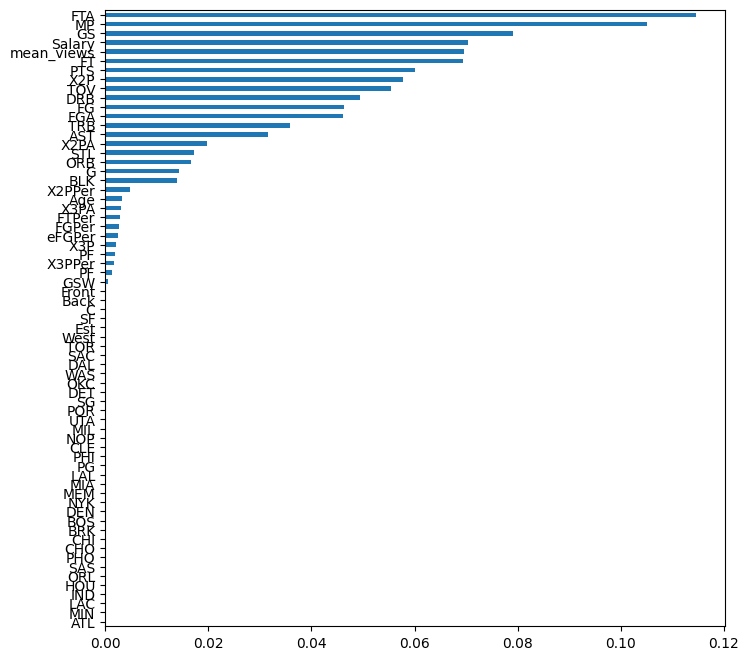

In [ ]:
var_imp = pd.DataFrame({'importance': rf_model_tuned.feature_importances_},
                       index=dat_16_17_X_train.columns)

var_imp.sort_values(by='importance').plot.barh(figsize=(8,8),
                                               legend=False);

Mirant la taula de resultats, escollim el model de kNN per a fer prediccions sobre el test i la resta de temporades.

Prediccions

In [ ]:
y_pred = knn.predict(dat_16_17_X_test)
results = pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

results.loc['test',:] = compute_metrics(dat_16_17_Y_test,y_pred)

results

,Accuracy,F1 Macro,Precision Macro,Recall Macro
test,0.963303,0.823625,0.823625,0.823625


In [ ]:
cm = confusion_matrix(dat_16_17_Y_test, y_pred)
print(cm) 

[[101   2]
 [  2   4]]


In [ ]:
y_pred = knn.predict(dat_17_18_X)

results.loc['17-18',:] = compute_metrics(dat_17_18_Y,y_pred)

results

,Accuracy,F1 Macro,Precision Macro,Recall Macro
test,0.963303,0.823625,0.823625,0.823625
17-18,0.959839,0.762223,0.774184,0.751396


In [ ]:
cm = confusion_matrix(dat_17_18_Y, y_pred)
print(cm) 

[[466   9]
 [ 11  12]]


In [ ]:
y_pred = knn.predict(dat_18_19_X)

results.loc['18-19',:] = compute_metrics(dat_18_19_Y,y_pred)

results

,Accuracy,F1 Macro,Precision Macro,Recall Macro
test,0.963303,0.823625,0.823625,0.823625
17-18,0.959839,0.762223,0.774184,0.751396
18-19,0.959916,0.787329,0.820088,0.761418


In [ ]:
cm = confusion_matrix(dat_18_19_Y, y_pred)
print(cm) 

[[441   7]
 [ 12  14]]
